In [9]:
import sys
sys.path.append("../")

import random
from queue import Queue

from pprint import pprint
from Core.maze import Maze, INF

In [10]:
def BinaryTree(maze, min_value):
    flag = 0
    for x in range(0, maze.num_rows):
        for y in range(0, maze.num_columns):
            temp = []
            if x > 0:
                temp.append('W')
            if y > 0:
                temp.append('N')
            if len(temp) == 0:
                continue
            direction = random.randint(0, len(temp)-1)
            maze.add_path((x, y), temp[direction], random.randint(min_value, 10))

In [11]:
def bfs(maze, source, sink):
    # setup
    n_rows = len(maze.grid)
    n_cols = len(maze.grid[0])
    visited = [[False]*n_cols for i in range(n_rows)]
    queue = Queue()
    parents = [[(-1, -1)]*n_cols for i in range(n_rows)]
    bottleneck = INF

    # initialization
    queue.put(source)
    
    # starting
    while not queue.empty():
        x, y = queue.get()
        current_node = maze.grid[x][y]
        
        # exit condition
        if (x, y) == sink:
            return True, parents, bottleneck

        # visited condition
        if visited[x][y]:
            continue
        # visiting the node
        visited[x][y] = True
        
        # going over the valid children nodes that can be accessed
        # through the edge
        if maze.grid[x][y].neighbors['N'] != INF and not visited[x-1][y]:
            queue.put((x-1, y))
            parents[x-1][y] = (x, y)
            bottleneck = min(bottleneck, maze.grid[x][y].neighbors['N'])

        if maze.grid[x][y].neighbors['S'] != INF and not visited[x+1][y]:
            queue.put((x+1, y))
            parents[x+1][y] = (x, y)
            bottleneck = min(bottleneck, maze.grid[x][y].neighbors['S'])

        if maze.grid[x][y].neighbors['W'] != INF and not visited[x][y-1]:
            queue.put((x, y-1))
            parents[x][y-1] = (x, y)
            bottleneck = min(bottleneck, maze.grid[x][y].neighbors['W'])

        if maze.grid[x][y].neighbors['E'] != INF and not visited[x][y+1]:
            queue.put((x, y+1))
            parents[x][y+1] = (x, y)
            bottleneck = min(bottleneck, maze.grid[x][y].neighbors['E'])

    
    return False, [], -1

In [12]:
def determine_direction(current_node, previous_node):
        """
        returns direction of path from previous node leading to current node
        """
        difference = (current_node[0]-previous_node[0], current_node[1]-previous_node[1])
        if difference == (1, 0):
            return 'N', 'S'
        if difference == (-1, 0):
            return 'S', 'N'
        if difference == (0, 1):
            return 'E', 'W'
        if difference == (0, -1):
            return 'W', 'E'

In [13]:
def augment_flows(maze, parents, source, sink, flow_possible):
    current_node = sink
    while current_node != source:
        previous_node = parents[current_node[0]][current_node[1]]
        direction, reverse_direction = determine_direction(current_node, previous_node)

        maze.grid[current_node[0]][current_node[1]].neighbors[reverse_direction] += flow_possible
        maze.grid[previous_node[0]][previous_node[1]].neighbors[direction] -= flow_possible
        
        current_node = previous_node
    return

In [14]:
def EdmondsKarp(maze, source, sink):
    flow = 0
    result, parents, flow_possible = bfs(maze, source, sink)
    
    while result and flow_possible:
        flow += flow_possible
        augment_flows(maze, parents, source, sink, flow_possible)
        result, parents, flow_possible = bfs(maze, source, sink)
    return flow

Enter N (dimension):  8


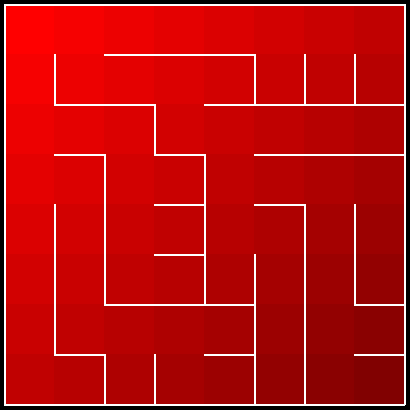

Max Flow is:  6


In [15]:
N = int(input("Enter N (dimension): ").strip())
maze = Maze(N,N)
BinaryTree(maze, random.randint(4, 24))
maze.add_colors()
display(maze.draw())

source = (0, 0)
sink = (N-1, N-1)

print("Max Flow is: ", EdmondsKarp(maze, source, sink))

# The Ford Fulkerson Algorithm

## Introduction
Imagine the start node of the maze as a server. The end point is your laptop, requesting for data packets to stream the Algorithm Analysis Class on Teams. Sometimes the speed is good, on the other times, it just ... painfully slow. But, what causes this slowness? The server is still up and running. Your internet connection hasn't crossed the data limit, so ... ? Whats going on?

There is, quite likey a slow tower in between, creating a bottleneck in the network speed that you receive. And yet, can you be absolutely sure, that the routing has done properly? Perhaps by choosing a better route, we could have increased the overall flow of data packets. 

Now, the question arises, how does one determine the best paths for the networks?

## Setup
If you have imagined the problem, its quite obvious now that you simply maximize the minimum tower speed, perhaps by choosing a better tower. Lets get a bit more abstract now.

The speed of the network can be thought of as a flow of data packets; the higher the speed, the higher the flow. Now its also apparent that certain towers in certain regions are good, and allow for a better speed by their design. On the flip side are the towers with poor design having low capacities overall.

The problem is now abstracted out in terms of a graph. The staring node, the server is what we call the source, while the ending node, your laptop is the sink, or, synonymously, the target. The towers in between are node in the grph. The nodes are connected with edges, dictating how much flow can be passed from one node to another. The flow's upper limit is its capacity. 

The problem is now to find such a path of nodes, which allow for a total maximum flow from the source to the sink.

One very important point to note is that decreasing the flow locally may increase the flow globally. We will explore and use this concept later on as well.

### Assumptions
For understanding this better, there are certain assumptions that we can make:
- source can give out an infinite amount of flow, and the sink can receive an infinite amount of flow.
- The total inflow for a node is the total outflow of a node; there is no stopping of flow. Imagine this as Kirchoff's Current laws, or, water flowing. No accumulation is allowed.
- Cycles of length 1 have no value, due to the above.

### Notations
Lets make this abstractions out into simple notations for easier proving.

| Label | Notation |
| - | - |
| Set of vertices | V |
| Set of edges | E |
| The Flow Network | G(V, E) |
| The Residual Flow Network | Gf(V, E) |
| Source | s |
| Sink | t |
| Disjoint Partition contatining s | S |
| Disjoint Partition contatining t | T |
| Capacity of edge from u->v | C(u, v) |
| Residual Capacity of Edge | Cf(u, v) |
| Residual Capacity of Graph | Cf(P) |
| Flow | f: V*V -> R |


### Formalising the Notations

So, lets formally write the assumptions we talked about, and how can we use them.
- **Flow**: A function f on G st f: VxV -> R
- **Capacity**: for all u, v belonging to V, we have f(u, v) <= C(u, v)
- **Flow Conservation**: for all u, v in V - {s, t}, sum(f(u, v)) = 0
- **Skew Symmetry**: f(u,v) = -f(v, u)
- |f| = sum(f(s, v) = f(s, V)
    - f(X, X) = 0
    - f(x, y) + f(y, x) = 0
    - f(X, Y) = -f(Y, X)
    - f(X union Y, Z) = f(X, Z) + f(Y, Z) if (X intersect Y) = NULL
- Prove: f(s, V) = f(V, t)
    - |f| = f(s, V)
    - f(V, V) = f(V-s, V) + f(s, V) = 0 [disjoint, f(X,X) = 0]
    - f(V-s, V) = -|f| = -f(V, V-s)
    - |f| = f(V, V-s) = f(V, V-s-t) + f(V, t) [since V-s-t and t are disjoint]
    - |f| = f(V, t) + 0 [conservation, intermediate sum to 0]
    - Hence Proved! |f| = f(V, t) = f(s, V)
- **cut**: (S, T) is a partition of s belonging to S, and t to T. Both are disjoint sets. S can ba any size >= 1, and same for T. (doesnt require flow to be max)
- *Lemma*: For ANY flow, and ANY cut (S, T), |f| = f(S, T). Note how it doesn't matter what nodes are in S and what nodes are in T. This *always* holds.
    - f(S, T) = f(S, V) - f(S, S) = f(S, V)
    - f(S, T) = f(V, T) - f(T, T) = f(V, T)
    - f(S, V) = f(S-s, V) + f(s, V) = f(s, V) [since there is no s or t in S-s.]
    - f(S, V) = f(s, V) = |f| = f(V, T)
- The capacity of any cut bounds the current flow. Since we can find flows for any arbitary partitions, we now simply find the min-cut, which is the bottle-neck. Reframing it, the min-cut is one case when the capacity = flow. Makes Sense!
- **Residual Network - Gf(V, Ef)**: local notion, saying there's still some flow left.
    - a residual edge Cf(u, v) = C(u, v) - f(u, v) > 0 (if 0, we don't add the edge)
    - edges with full capacity are not shown in the residual network
    - edges not in full capacity show up with 2 edges: reverse edge and remaining edge capacity.
    - edges not used show up as 1 reverse edge.
- **Augmenting paths**: If path from s to t exists, we can always add atleast 1 more unit of flow.
- **Residual Capacity - Cf(P)**: take the min of all the edge weights used to traverse the augmenting path(P).
    - Cf(P) = min(Cf(u, v)) for all u, v


## Ford Fulkerson
At last! The Ford fulkerson algorithm

Initialize:
start with f(u, v) = 0 for all u and v

```
while augmenting_path(Gf):
    augment f by Cf(P)
```

Thats it!

### Proof
How can we be sure this works? How do we know that the flow returned will be the maximum possible flow?

Lets consider the three equivalent statements:
1. |f| = C(S, T) for some cut (S, T) (the bottleneck cut)
2. f is maximum flow
3. f admits no augmenting paths

For the proof, we need to prove 3->2.

Proving 1->2:
since |f| <= C(S, T), |f| = C(S, T) implies that |f| is the maximum, and can't be increased

Proving 2->3:
If an augmenting path exists, the flow can be increased. This contradicts the above, thus is not possible.

Proving 3->1:
So f doesnt admit more augmenting paths.
Now, we know 

S = {u: for all u in Gf, there is a path form s to u}
T = V-S

s belongs to S
t belongs to T

Now, consider nodes u in S and v in T respectively. No edge from u to v in Gf, since if there wa, we would have included v in S.

Lets just say that u to v has an edge in G (the original). The only case when this happens is when the u -> v edge is saturated. Formally,

Cf(u, v) = 0 since if Cf(u, v) > 0, then v belongs to S, and not T. this is contradiction.
So, Cf(u, v) = 0

Thus, Cf(u, v) = C(u, v) - f(u, v) = 0
Thus, f(u, v) = C(u, v)

This means that that cut has reached full capacity.
summing over all u in S and v in T, f(S, T) = C(S, T)

DONE!

### Problem
Have a look at

![](https://i.imgur.com/QEpVjgC.png)

Running the Fork Fulkerson algorithm is a BAD idea (Why?)

Paradox: We said that running time is a fintite amount, why the infinite time then? We assume that the search alogithms are randomly picking nodes. If this is deterministic, we have infinite time complexity.

NOTE: I have skipped using the edge capacities as non-integers, since that goes beyond the scope of our exploration as well as applications.

### Complexity
Using either BFS or DFS to find each augmenting path takes O(|V|+|E|) time and consumes O(|V|) space. (Refer to BFS/DFS Algorithms)
In the worst case, having total Flow as F, we may need to increase the flows by 1 each time. 

Thus, the time complexity is O((|V|+|E|) * F)
Thus, the space complexity is O(|V| * F)

For our case of maze, we have N^2 nodes. Each node has 4 edges, and thus |V| = N^2 and |E| = 4*N^2.

Now, the question is, we do not have F precomputed (if we have, there no point in running this algorithm!). How do we find F? This depends now on the choice of search.

### Edmonds karp to the Rescue
Edmonds Karp dodges the problem of ford-fulkerson killer like graphs by using a BFS approach to find the augmenting paths.

For the complexity, each edge in the graph has to be explored by BFS. This takes O(|E|) time. Now, what are the total number of iterations? O(|V||E|). 
 
[How](https://jamieheller.github.io/theory.html)